# Report figures notebook

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# suppress info and warn TF logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import gc
import time
import cv2
import tifffile as tiff
import numpy as np
import matplotlib
import nibabel as nib
import neurite as ne
import voxelmorph as vxm
import mpl_toolkits.axisartist as AA
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
from IPython.display import Video

plt.rcParams["animation.html"] = "jshtml" 
plt.rcParams["animation.embed_limit"] = "500"  # size limit in MB

# Font size
plt.style.use('default')

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%reload_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

from stabilize2p.utils import make_video

def frame_gen(video, scores=None, lt=0.9):
    low, hig = video[0].min(), video[1].max()
    if scores is not None:
        for img, score in zip(video, scores):
            img = (img - low) / (hig - low) * 255
            img[img < 0] = 0
            img[img > 255] = 255
            img = img.astype(np.uint8)
            if score < lt:
                img[:50, :50] = 255
            else:
                img[:50, :50] = 0
            yield img
    else:
        for img in video:
            img = (img - low) / (hig - low) * 255
            img[img < 0] = 0
            img[img > 255] = 255
            img = img.astype(np.uint8)
            yield img

orig_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/006_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/007_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/008_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/009_coronal/2p/denoised_red.tif'
]

ofco_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/006_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/007_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/008_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/009_coronal/2p/warped_red.tif'
]

pystackreg_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/006_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/007_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/008_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/009_coronal/2p/denoised_red.pystackreg-affine.tif',
]

RANDOM_SEED = 1

os.makedirs('report', exist_ok=True)

# Title

In [52]:
from stabilize2p.metrics import MSE
image = tiff.imread(orig_examples[0])

MSE(image, ref='first', return_all=True).argmax()

1438

In [5]:
from stabilize2p.utils import get_strategy
os.makedirs('report/title', exist_ok=True)

strategy = get_strategy('GPU')


# retrieve dataset shape
in_shape = tiff.imread(orig_examples[0], key=0).shape

# unet architecture
enc_nf = [16, 32, 32, 128, 128]
dec_nf = [128, 128, 32, 32, 32, 16, 16]


# build model using VxmDense
with strategy.scope():
    vxm_model = vxm.networks.VxmDense(in_shape, [enc_nf, dec_nf], int_steps=0)
    vxm_model.load_weights('../models/vxm_drosophila_2d_1000.h5')

[2021-12-08 18:05:40,669] I T140456538862400 utils.py:840: Num Physical GPUs Available: 1
[2021-12-08 18:05:40,669] I T140456538862400 utils.py:841: Num Logical  GPUs Available: 1
[2021-12-08 18:05:40,670] I T140456538862400 utils.py:842: Num TPUs Available: 0
[2021-12-08 18:05:40,670] W T140456538862400 utils.py:852: GPU device "PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')" is already initialized.


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


[2021-12-08 18:05:40,672] I T140456538862400 utils.py:868: using GPU "MirroredStrategy" strategy.


In [53]:
from stabilize2p.utils import vxm_data_generator

store_params = []
val_generator = vxm_data_generator(orig_examples[0],
                                   batch_size=8,
                                   keys=[[1, 1438]],
                                   training=False,
                                   ref='first',
                                   store_params=store_params)

val_pred = []
for (val_input, _) in val_generator:
    val_pred += [vxm_model.predict(val_input, verbose=2)]
val_pred = [
    np.concatenate([a[0] for a in val_pred], axis=0),
    np.concatenate([a[1] for a in val_pred], axis=0)
]

# undo pre-processing
params = store_params[0]
h, l = params.pop('hig'), params.pop('low')
val_pred[0] = val_pred[0] * (h - l) + l
val_pred[0] = np.exp(val_pred[0]) - 1
val_pred[0] = val_pred[0] + params['bg_thresh']

val_pred[0].shape, val_pred[1].shape

[2021-12-08 18:29:44,809] I T140456538862400 utils.py:162: Calculated "first" fixed references in 0.00654s


1/1 - 0s - 36ms/epoch - 36ms/step


2021-12-08 18:29:44.901524: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_3551"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:109"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. Yo

((2, 480, 736, 1), (2, 480, 736, 2))

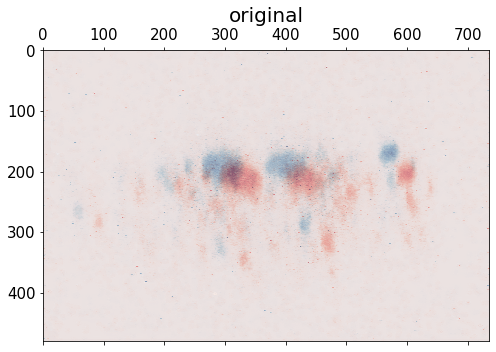

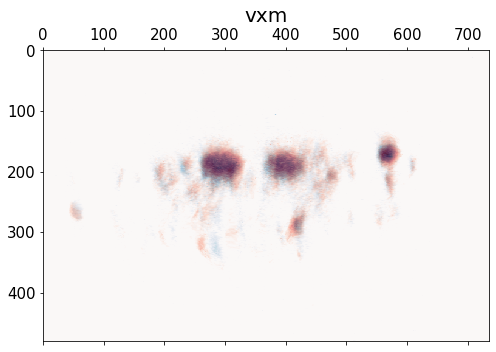

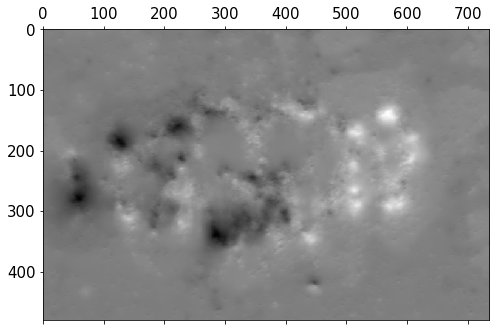

(480, 736, 1)


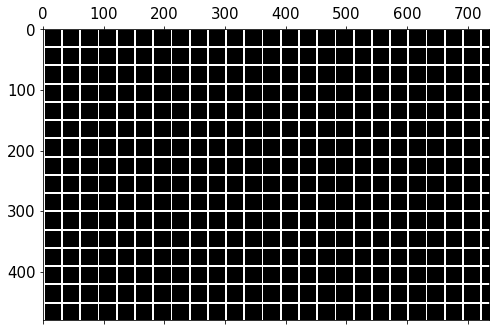

grid.shape=(1, 480, 736, 1)
in_shape=(480, 736)
warp.shape=(1, 480, 736, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


deform_field.shape=(1, 480, 736, 1)


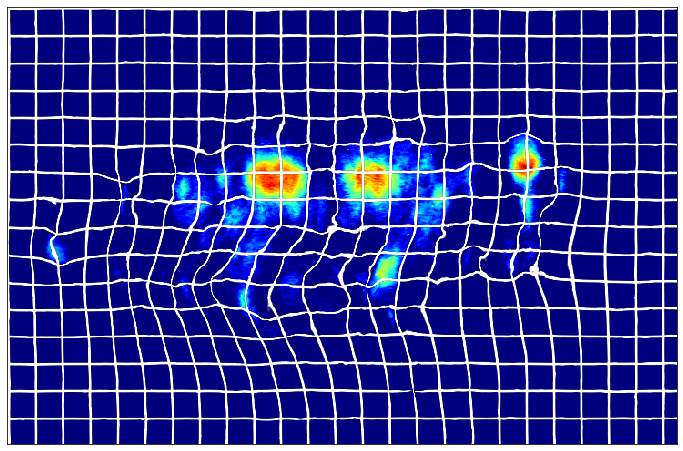

In [64]:
image = tiff.imread(orig_examples[0], key=[1, 1438])

_, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.matshow(image[0], cmap='Blues')
ax.matshow(image[1], cmap='Reds', alpha=0.5)
ax.set_title('original')
plt.show()

_, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.matshow(val_pred[0][0, ..., 0], cmap='Blues')
ax.matshow(val_pred[0][1, ..., 0], cmap='Reds', alpha=0.5)
ax.set_title('vxm')
plt.show()

_, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.matshow(val_pred[1][1, ..., 0], cmap='gray')
plt.show()

sh = val_pred[0].shape[1:]
print(sh)
grid = np.zeros(sh)
ds = 30
grid[::ds, :] = 1.0
grid[1::ds, :] = 1.0
grid[2::ds, :] = 1.0
grid[:, ::ds] = 1.0
grid[:, 1::ds] = 1.0
grid[:, 2::ds] = 1.0
_, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.matshow(grid, cmap='gray')
plt.show()

grid = grid[np.newaxis, ...]
print(f'{grid.shape=}')
print(f'{in_shape=}')
warp = val_pred[1][1][np.newaxis, ...]
print(f'{warp.shape=}')

deform_field = vxm.networks.Transform(in_shape, nb_feats=1)\
        .predict([grid, warp])
print(f'{deform_field.shape=}')

deform_field = np.tile(deform_field[0], (1, 1, 4))
# deform_field[..., 3] = deform_field[..., 

_, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.matshow(val_pred[0][1], cmap='jet')
ax.matshow(deform_field, cmap='gray')
ax.tick_params(left=False,
                bottom=False,
                top=False,
                labeltop=False,
                labelleft=False,
                labelbottom=False)
plt.savefig('report/title/title.svg')
plt.show()

# Dataset overview

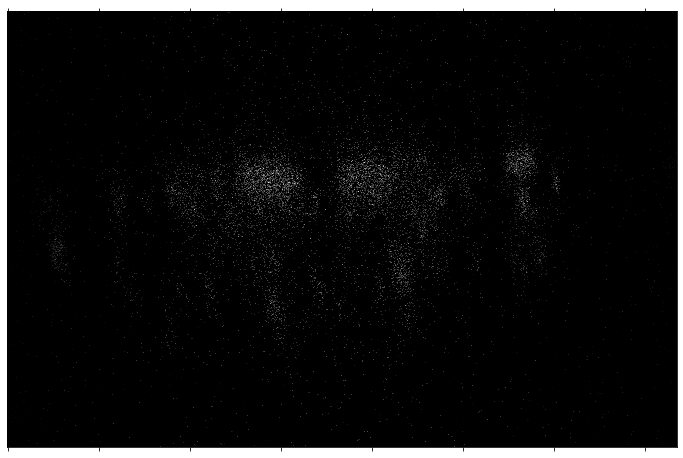

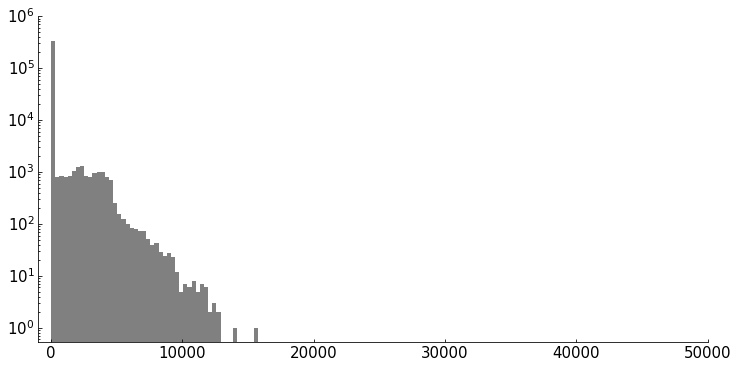

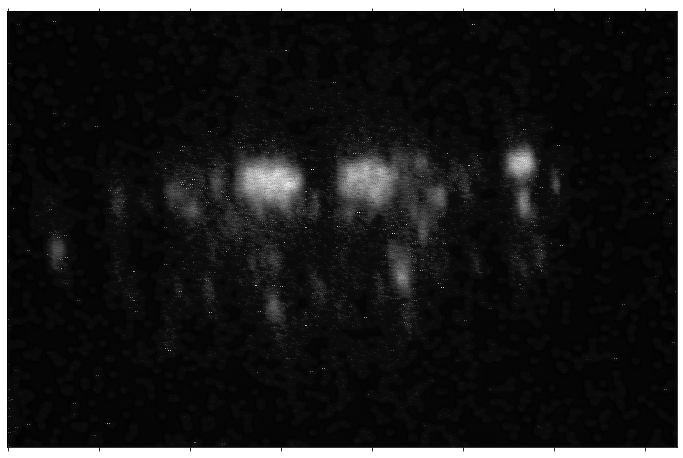

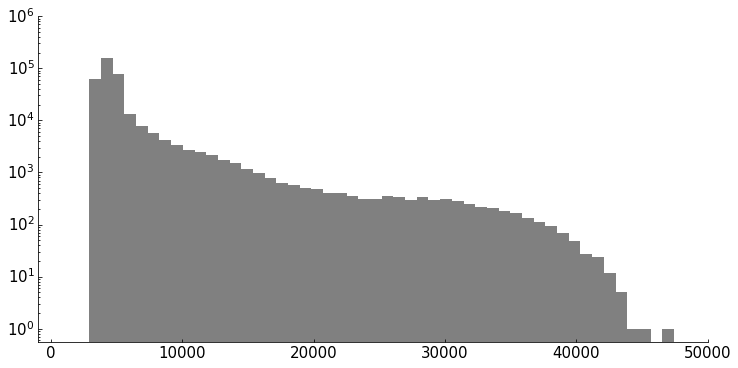

In [37]:
os.makedirs('report/dataset-overview', exist_ok=True)

def plot(path, name):
    img = tiff.imread(path, key=0)
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(1,1,1)
    ax.tick_params(left=False,
                    bottom=False,
                    labelleft=False,
                    labelbottom=False)
    ax.matshow(img, cmap='gray')

    plt.savefig(f'report/dataset-overview/{name}.svg')
    plt.show()

    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(1,1,1, axes_class=AA.Axes)
    for direction in ["right", "top"]:
        # hides borders
        ax.axis[direction].set_visible(False)
    ax.set_yscale('log')
    ax.hist(img.ravel(), bins=50, color='gray')
    ax.set_ylim(None, 1e6)
    ax.set_xlim(-1000, 50_000)

    plt.savefig(f'report/dataset-overview/{name}-hist.svg')
    plt.show()
    

path = '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/red.tif'
plot(path, 'raw')



path = '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.tif'
plot(path, 'denoised')

# Metrics

In [138]:
from stabilize2p.utils import plot_centers

os.makedirs('report/metrics', exist_ok=True)

In [139]:
from stabilize2p.utils import get_centers

cs = []
for path in orig_examples:
    print(f'reading {path} ..')
    image = tiff.imread(path)
    cs.append(get_centers(image))
cs = np.array(cs)
np.save('report/metrics/centers', cs)
print(f'{cs.shape=}')

reading ../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.tif ..
reading ../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.tif ..
reading ../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.tif ..
reading ../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.tif ..
reading ../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif ..
reading ../data/200901_G23xU1/Fly1/Fly1/006_coronal/2p/denoised_red.tif ..
reading ../data/200901_G23xU1/Fly1/Fly1/007_coronal/2p/denoised_red.tif ..
reading ../data/200901_G23xU1/Fly1/Fly1/008_coronal/2p/denoised_red.tif ..
reading ../data/200901_G23xU1/Fly1/Fly1/009_coronal/2p/denoised_red.tif ..
cs.shape=(9, 4100, 2)


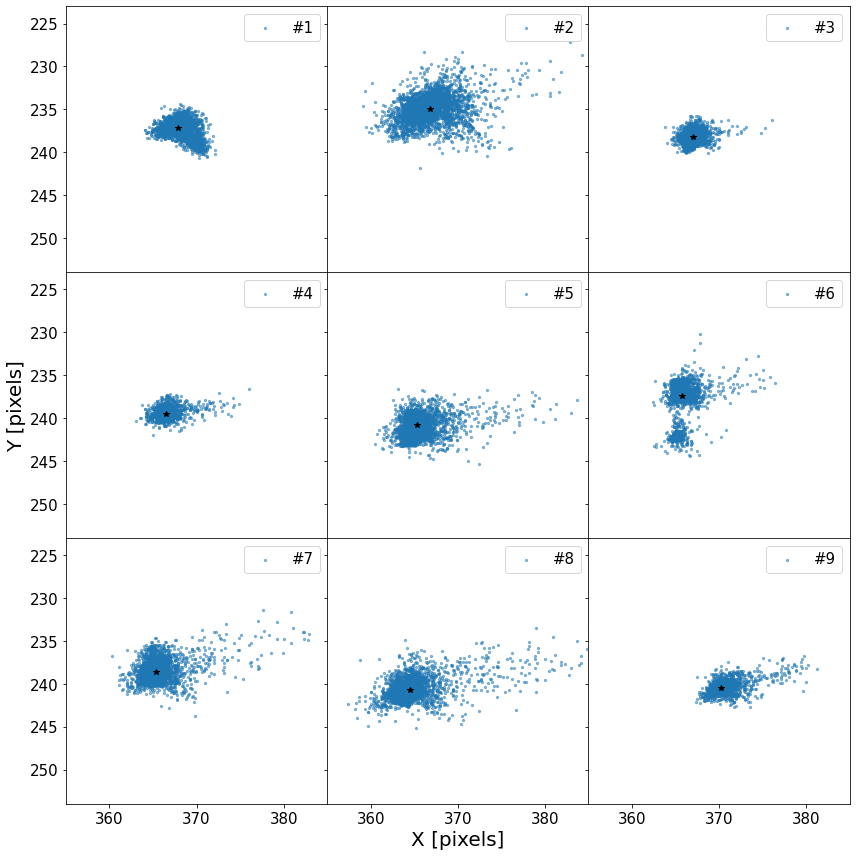

In [140]:
def plot_centers(centers, ax, label):
    size = 5
    target = centers.mean(axis=0)

    ax.scatter(centers[:, 0], centers[:, 1], color='tab:blue', s=size, alpha=0.5, label=label)
    ax.plot(target[0], target[1], 'k*')

    
cs = np.load('report/metrics/centers.npy')
_, axes = plt.subplots(3, 3, figsize=(4*3, 4*3),
                       sharex='all', sharey='all',
                       gridspec_kw=dict(wspace=0, hspace=0))

for i, ax in enumerate(axes.ravel()):
    plot_centers(cs[i], ax=ax, label=f'#{i+1}')
    ax.set_xlim(355, 385)
    ax.set_ylim(254, 223)
    ax.legend()

axes[1, 0].set_ylabel(r'Y [pixels]')
axes[2, 1].set_xlabel(r'X [pixels]')

plt.tight_layout()
plt.savefig('report/metrics/com-example.pdf')

# Thresholding

In [88]:
from stabilize2p import threshold

os.makedirs('report/thresholding', exist_ok=True)

methods = [
    threshold.otsu,
    threshold.triangle,
    threshold.watershed,
    threshold.second_deriv
]

path='../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_green.tif'
otsu: $T=385$
triangle: $T=267$
watershed: $T=186$
second_deriv: $T=202$


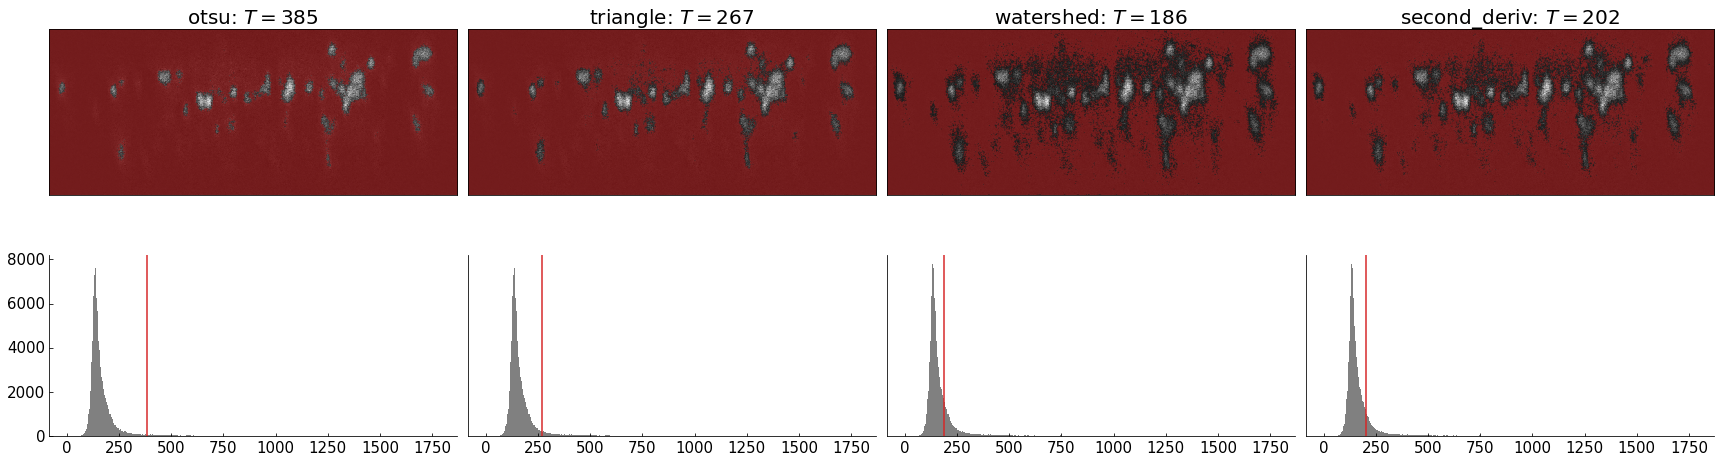

In [194]:

green = True

if green:
    path = orig_examples[0].replace('red', 'green')
else:
    path = orig_examples[0]
print(f'{path=}')
image = tiff.imread(path, key=0)
mask_color = mcolors.to_rgb(mcolors.TABLEAU_COLORS['tab:red'])

fig, axes = plt.subplots(2, len(methods),
                         figsize=(6*len(methods), 4*2),
                         subplot_kw=dict(axes_class=AA.Axes),
                         gridspec_kw=dict(height_ratios=[0.7, 0.3]),
                         sharey='row', sharex='row')

# apply thresholds
for i, meth, ax in zip(range(len(methods)), methods, axes.T):
    th = meth(image)
    title = f'{meth.__name__}: $T='f'{th:,.0f}$'.replace(',', '\'')
    print(title)
    
    ax[0].matshow(image, cmap='gray')

    alpha = 0.5
    mask = (image < th).astype(float) * alpha
    mask = np.tile(mask[..., np.newaxis], (1, 1, 4))
    mask[..., [0, 1, 2]] = mask_color
    ax[0].imshow(mask)

    for direction in ["right", "top", "bottom", "left"]:
        ax[0].axis[direction].major_ticks.set_visible(False)
        ax[0].axis[direction].major_ticklabels.set_visible(False)
    ax[0].set_title(title)

    # histogram
    for direction in ["right", "top"]:
        # hides borders
        ax[1].axis[direction].set_visible(False)
    if i > 0:
        ax[1].axis['left'].major_ticks.set_visible(False)
        ax[1].axis['left'].major_ticklabels.set_visible(False)
    # ax[1].set_yscale('log')
    ax[1].hist(image.ravel(), bins=600, color='gray')
    ax[1].axvline(th, c='tab:red')
    # ax.set_ylim(None, 1e6)
    if green:
        pass
    else:
        ax[1].set_xlim(None, 30_000)

plt.tight_layout()
if green:
    plt.savefig('report/thresholding/thresholds-green.svg')
else:
    plt.savefig('report/thresholding/thresholds.svg')
plt.show();

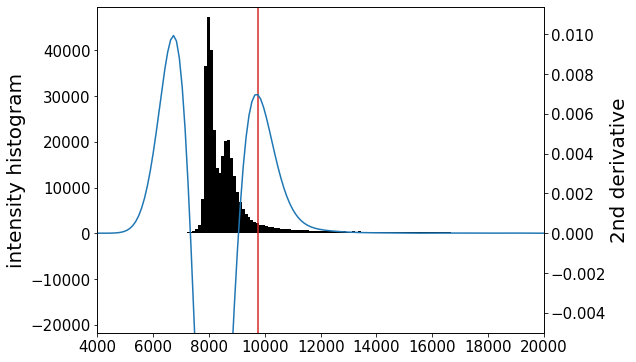

In [153]:
import cv2
from scipy import ndimage as ndi
from skimage.feature import peak_local_max

hist, bns = np.histogram(image, bins=400)
dx = bns[1] - bns[0]
grad = (hist[1:] - hist[:-1]) / dx
grad = cv2.GaussianBlur(grad, (1, 31), 0)
grad2 = (grad[1:] - grad[:-1]) / dx
grad2 = cv2.GaussianBlur(grad2, (1, 31), 0)
coords = peak_local_max(grad2.ravel(), num_peaks=2)

i = coords.max()
T = bns[i:(i+1)].mean()

xaxis = bns.ravel()[:-1]

_, ax = plt.subplots(1,1,figsize=(8, 6))
ax.bar(xaxis, hist.ravel(), width=dx, color='black')
ax.set_ylabel('intensity histogram')
twinax = ax.twinx()
twinax.plot(xaxis[:-2], grad2.ravel(), color='tab:blue')
twinax.set_ylim(-0.005, None)
twinax.set_ylabel('2nd derivative')
ax.axvline(T, c='tab:red')
ax.set_xlim(4000, 20_000)

l1, h1 = ax.get_ylim()
l2, h2 = twinax.get_ylim()
ax.set_ylim(h1/h2 * l2, h1)

plt.savefig('report/thresholding/second-deriv.svg')
plt.show()

# Normalization

image.min()=-0.6705882352944172
gs=GridSpec(1, 2)


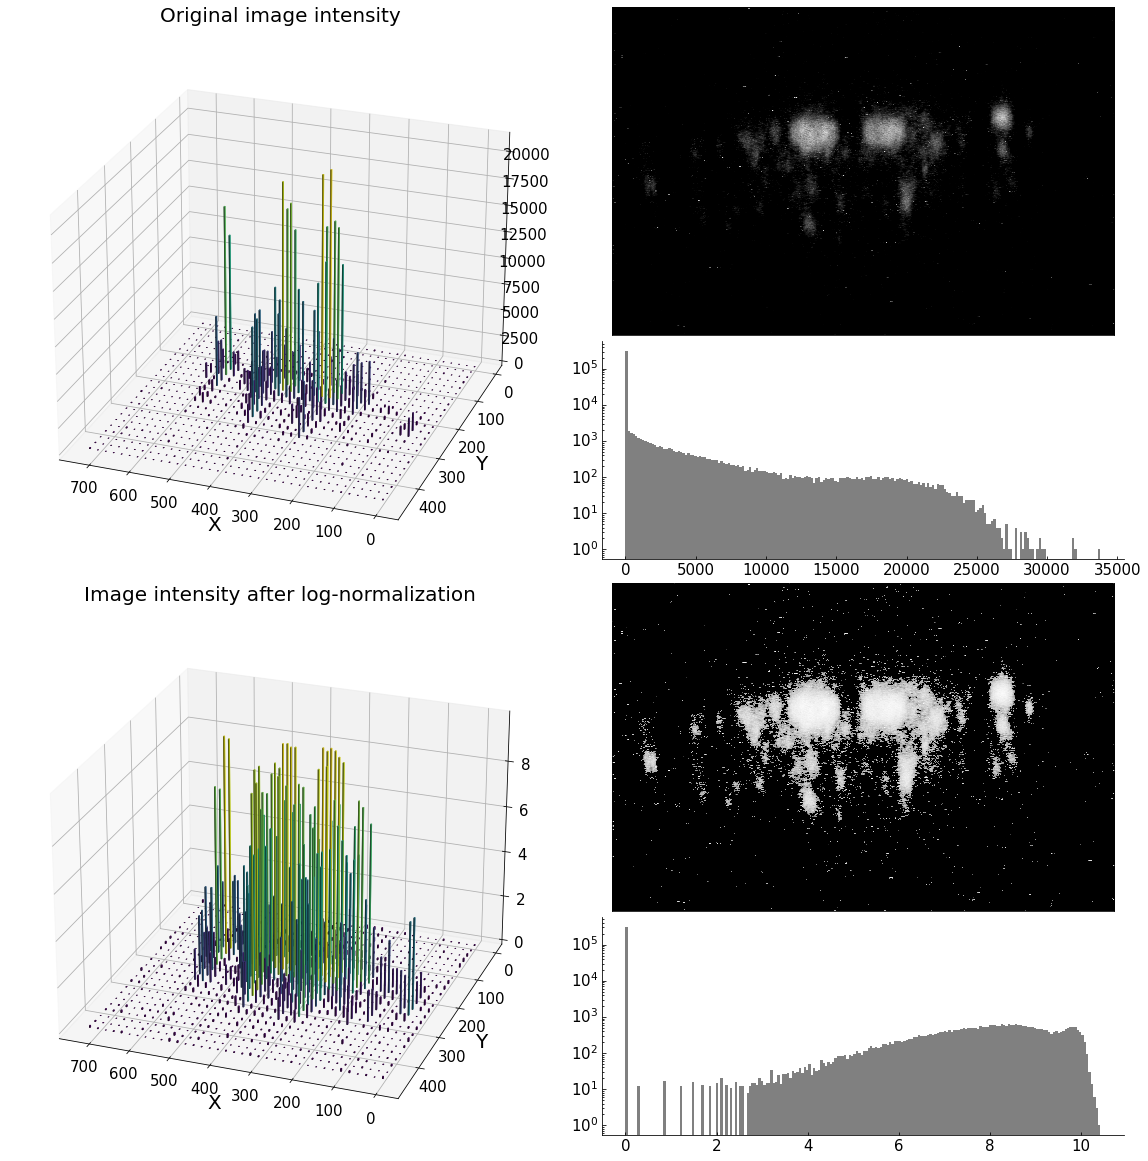

In [136]:
from stabilize2p import threshold
from stabilize2p.utils import plot_frame_values_3d
import matplotlib.gridspec as gridspec
image = tiff.imread(orig_examples[0], key=0)

os.makedirs('report/normalization', exist_ok=True)

th = threshold.triangle(image)
np.clip(image, th, None, out=image)
image = image - th
print(f'{image.min()=}')

## PLOT
fig = plt.figure(figsize=(16, 16), constrained_layout=True)

gs = gridspec.GridSpec(1, 2, figure=fig)
print(f'{gs=}')

def plot_img(fig, sub_gs):
    ax = fig.add_subplot(sub_gs[0], axes_class=AA.Axes)
    ax.matshow(image, cmap='gray')
    for direction in ["right", "top", "bottom", "left"]:
        ax.axis[direction].major_ticks.set_visible(False)
        ax.axis[direction].major_ticklabels.set_visible(False)
    ax = fig.add_subplot(sub_gs[1], axes_class=AA.Axes)
    ax.hist(image.ravel(), bins=200, color='gray')
    ax.set_yscale('log')
    for direction in ["right", "top"]:
        # hides borders
        ax.axis[direction].set_visible(False)


gs_3d = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0])
sub_gs = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=gs[1],
                                          height_ratios=[0.3, 0.2, 0.3, 0.2])

ax = fig.add_subplot(gs_3d[0], projection='3d')
plot_frame_values_3d(image, ax=ax, pool=20, cmap='viridis')
ax.set_title(r'Original image intensity')

plot_img(fig, sub_gs)

I = image
# l, h = I.min(), I.max()
# I = (I - l) / (h - l)
image = np.clip(np.log(1 + I), 0, None)

ax = fig.add_subplot(gs_3d[1], projection='3d')
plot_frame_values_3d(image, ax=ax, pool=20, cmap='viridis')
ax.set_title(r'Image intensity after log-normalization')

plot_img(fig, [sub_gs[2], sub_gs[3]])

plt.savefig('report/normalization/log-norm.pdf')
plt.show()

# PyStackReg

radius=48.0
x: 361.84 + 3.38
y: 220.37 + 1.32


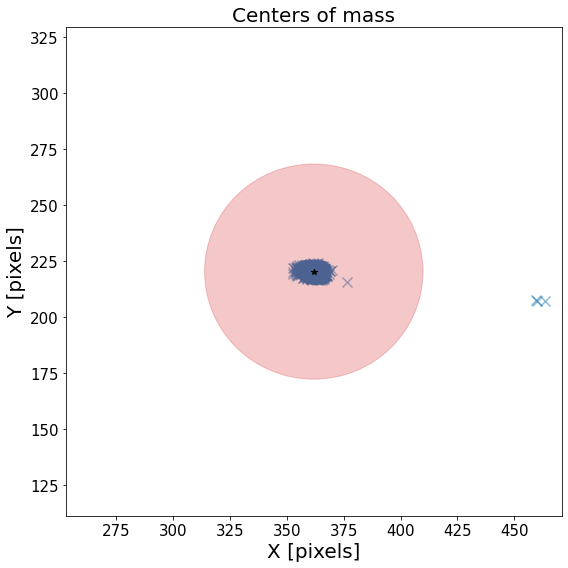

COM: 0.0732%


In [39]:
from stabilize2p.metrics import COM
from stabilize2p.utils import plot_centers, vxm_preprocessing

os.makedirs('report/pystackreg', exist_ok=True)

path = pystackreg_examples[1]
print(f'{path=}')
image = tiff.imread(path)

t1 = time.perf_counter()
image, params = vxm_preprocessing(image, affine_transform=False)
gc.collect()
t2 = time.perf_counter()
print(f'pre-processed image in {t2-t1}s')

plt.figure(figsize=(8, 8))
plot_centers(image, s=100, marker='x')
plt.ylabel('Y [pixels]')
plt.xlabel('X [pixels]')
plt.tight_layout()
plt.savefig('report/pystackreg/pysreg-com-exapmle.pdf')
plt.show()

com = COM(image)
print(f'COM: {com*100:.4f}%')

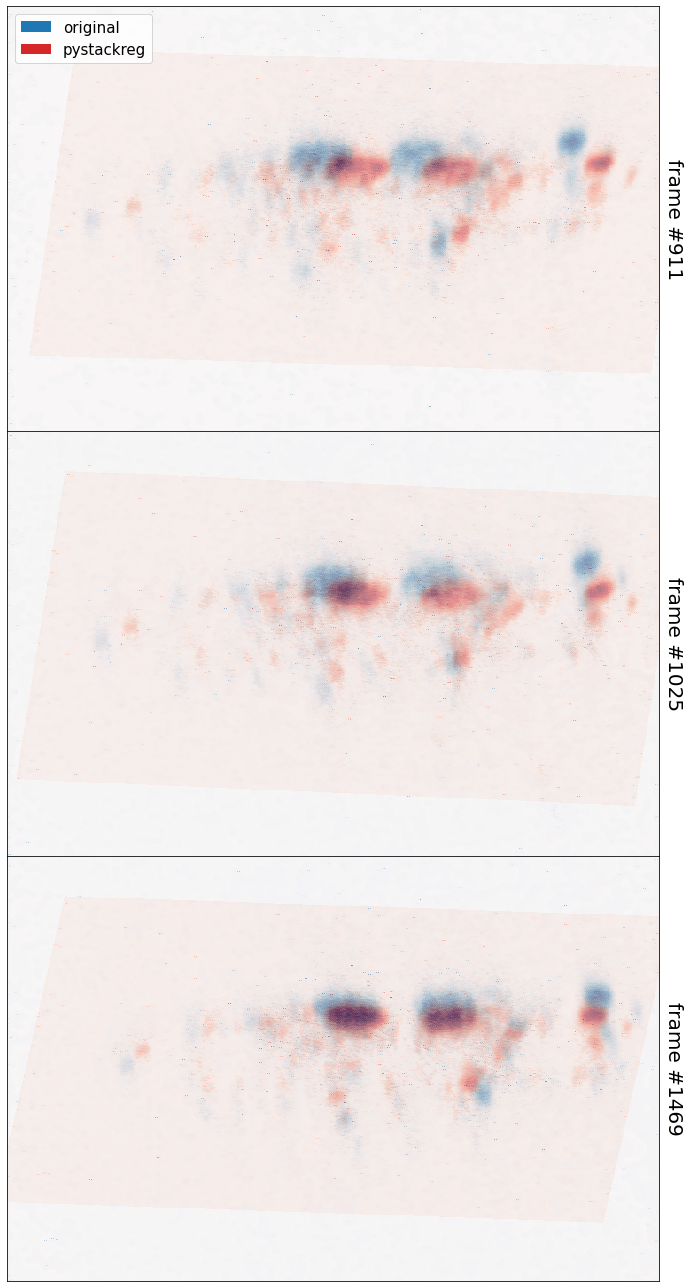

In [38]:
from matplotlib.patches import Patch

# fails = COM(image, return_all=True)
fails_idx = np.where(fails)[0]

_, axes = plt.subplots(len(fails_idx), 1,
                       figsize=(10, 6*len(fails_idx)),
                       sharex='col',
                       gridspec_kw=dict(wspace=0, hspace=0),
                       subplot_kw=dict(axes_class=AA.Axes))
for i, ax in zip(fails_idx, axes):
    orig_img = tiff.imread(orig_examples[1], key=i)
    img = tiff.imread(path, key=i)
    # undo pre-processing
    # h, l = params['hig'], params['low']
    # img = img * (h - l) + l
    # img = np.exp(img) - 1
    # img = img + params['bg_thresh']

    ax.matshow(orig_img, cmap='Blues')
    ax.matshow(img, cmap='Reds', alpha=0.5)
    for direction in ["right", "top", "bottom", "left"]:
        ax.axis[direction].major_ticks.set_visible(False)
        ax.axis[direction].major_ticklabels.set_visible(False)
    ax.axis["right"].toggle(label=True)
    ax.axis["right"].set_label(f'frame #{i+1}')
    ax.axis["right"].label.set_axis_direction('left')
    # ax.yaxis.tick_right()

    del orig_img, img
    gc.collect()

axes[0].legend(handles=[
    Patch(facecolor='tab:blue', label=r'original'),
    Patch(facecolor='tab:red', label=r'pystackreg'),
  ],
  loc='upper left')
plt.tight_layout()
plt.savefig('report/pystackreg/pysreg-fail-examples.pdf')
plt.show()

# Voxelmorph

## architecture input-output frames

In [82]:
import os
from stabilize2p.utils import vxm_preprocessing
os.makedirs('report/voxelmorph', exist_ok=True)

key = range(2000, 2008)
image = tiff.imread(orig_examples[4], key=key)
processed, params = vxm_preprocessing(image)
del image
print(f'{processed.shape=}')

def transform(I, to_uint=True):
    if to_uint:
        l, h = I.min(), I.max()
        I = (I-l)/(h-l) * 255
        I = I.astype('uint8')
        I = cv2.applyColorMap(I, cv2.COLORMAP_VIRIDIS)
    I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
    _, W, C = I.shape
    I = np.concatenate([I, 255*np.ones((I.shape[0], W, 1), dtype='uint8')], axis=2)
    margins_up = np.zeros((I.shape[0]//3, W, C+1), dtype='uint8')
    margins_down = np.zeros((I.shape[0]//2, W, C+1), dtype='uint8')
    I = np.concatenate([margins_up, I, margins_down], axis=0)
    H = I.shape[0]
    M2 = np.float32([[1, 0, 0], [-0.5, 1, 0]])
    M2[0,2] = -M2[0,1] * W/2
    M2[1,2] = -M2[1,0] * H/2
    I = cv2.warpAffine(I, M2, (W, H))
    I = cv2.resize(I, (W//2, H))
    return I

for i, I in enumerate(processed):
    I = transform(I)

    _, ax = plt.subplots(1, 1,
                         subplot_kw=dict(axes_class=AA.Axes))
    for direction in ["right", "top", "bottom", "left"]:
        ax.axis[direction].set_visible(False)
    ax.imshow(I)
    plt.savefig(f'report/voxelmorph/in_{i}.svg', transparent=True)
    plt.close()

# load vxm model and predict
vxm_model = vxm.networks.VxmDense.load('../models/vxm_drosophila_2d_1900.h5')
fixed = np.concatenate([processed[:1], processed[:-1]], axis=0)
print(f'{fixed.shape=}')
moved, flow = vxm_model.predict([processed[..., np.newaxis], fixed[..., np.newaxis]])
moved, flow = moved.squeeze(), flow.squeeze()
del fixed
print(f'{moved.shape=}')

for i, I in enumerate(moved):
    I = transform(I)

    _, ax = plt.subplots(1, 1,
                         subplot_kw=dict(axes_class=AA.Axes))
    for direction in ["right", "top", "bottom", "left"]:
        ax.axis[direction].set_visible(False)
    ax.imshow(I)
    plt.savefig(f'report/voxelmorph/out_{i}.svg', transparent=True)
    plt.close()

for i, f in enumerate(flow):
    ne.plot.flow([f[::10, ::10]], show=False)
    plt.savefig(f'report/voxelmorph/flow_out_{i}.png')
    plt.close()
    
    I = cv2.imread(f'report/voxelmorph/flow_out_{i}.png')
    I = transform(I, to_uint=False)

    _, ax = plt.subplots(1, 1,
                         subplot_kw=dict(axes_class=AA.Axes))
    for direction in ["right", "top", "bottom", "left"]:
        ax.axis[direction].set_visible(False)
    ax.imshow(I)
    plt.savefig(f'report/voxelmorph/flow_out_{i}.svg', transparent=True)
    plt.close()
print('Done')

[2022-01-11 00:56:38,590] D T140509901460288 utils.py:383: Applied affine transform to 8 frames at a rate of 40 frames/s


processed.shape=(8, 480, 736)
fixed.shape=(8, 480, 736)
moved.shape=(8, 480, 736)
Done


In [83]:
!rm report/voxelmorph/*.png

/bin/bash: /home/adrian/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


# Results

## COM threshold sensitivity analysis

In [40]:
import gc
from stabilize2p.utils import vxm_preprocessing, get_centers

def COM(centers, threshold):
    # consider a frame wrong if the axis is > 10% off the mean
    m_center = centers.mean(axis=0)
    failures = np.sum((centers - m_center)**2, axis=1) > threshold**2
    return np.sum(failures) / centers.shape[0]

In [20]:
orig_centers = []
for fp in orig_examples:
    print(f'reading {fp} ..')
    x = tiff.imread(fp)
    image, _ = vxm_preprocessing(x, affine_transform=False)
    print('finished preproc')

    orig_centers.append(get_centers(image))
    del image
    gc.collect()
orig_centers = np.array(orig_centers)
np.save('report/pystackreg/orig_centers', orig_centers)

pysreg_centers = []
for fp in pystackreg_examples:
    print(f'reading {fp} ..')
    x = tiff.imread(fp)
    image, _ = vxm_preprocessing(x, affine_transform=False)
    print('finished preproc')

    pysreg_centers.append(get_centers(image))
    del image
    gc.collect()
pysreg_centers = np.array(pysreg_centers)
np.save('report/pystackreg/pysreg_centers', pysreg_centers)


ofco_centers = []
for fp in ofco_examples[5:]:
    print(f'reading {fp} ..')
    x = tiff.imread(fp)
    image, _ = vxm_preprocessing(x, affine_transform=False)
    print('finished preproc')

    ofco_centers.append(get_centers(image))
    del image
    gc.collect()
ofco_centers = np.array(ofco_centers)
np.save('report/pystackreg/ofco_centers', ofco_centers)

reading ../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.tif ..
finished preproc
reading ../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.tif ..
finished preproc
reading ../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.tif ..
finished preproc
reading ../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.tif ..
finished preproc
reading ../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif ..
finished preproc
reading ../data/200901_G23xU1/Fly1/Fly1/006_coronal/2p/denoised_red.tif ..
finished preproc
reading ../data/200901_G23xU1/Fly1/Fly1/007_coronal/2p/denoised_red.tif ..
finished preproc
reading ../data/200901_G23xU1/Fly1/Fly1/008_coronal/2p/denoised_red.tif ..
finished preproc
reading ../data/200901_G23xU1/Fly1/Fly1/009_coronal/2p/denoised_red.tif ..
finished preproc


In [24]:
# scores
MAX_TH = 100
thresholds = np.linspace(0, MAX_TH, 100)
orig_scores = []
pysreg_scores = []
ofco_scores = []
for th in thresholds:
    orig_scores.append([
        COM(cs, th) * 100.0
        for cs in orig_centers
    ])
    pysreg_scores.append([
        COM(cs, th) * 100.0
        for cs in pysreg_centers
    ])
    ofco_scores.append([
        COM(cs, th) * 100.0
        for cs in ofco_centers
    ])
orig_scores = np.array(orig_scores).T
pysreg_scores = np.array(pysreg_scores).T
ofco_scores = np.array(ofco_scores).T
print(f'{orig_scores.shape=} | {pysreg_scores.shape=} | {ofco_scores.shape=}')

orig_scores.shape=(9, 100) | pysreg_scores.shape=(9, 100) | ofco_scores.shape=(9, 100)


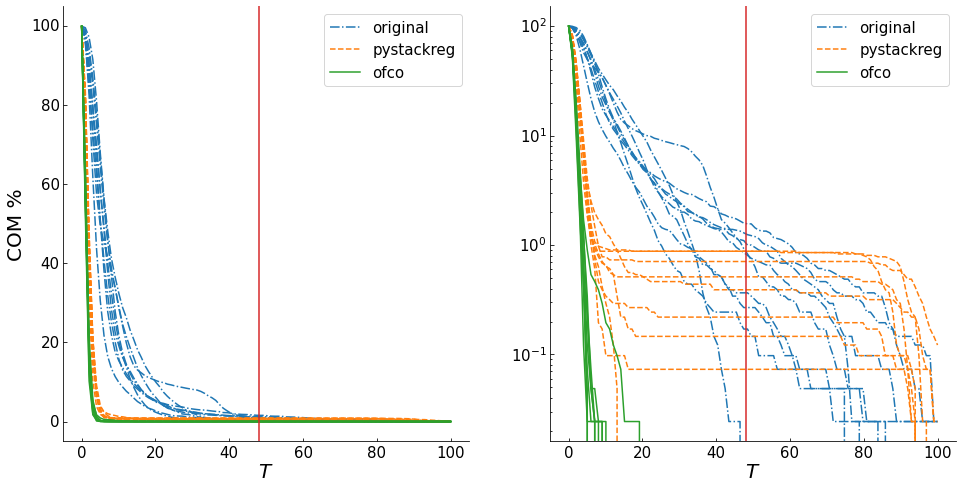

In [64]:
xaxis = thresholds
T = 48

fig, axes = plt.subplots(1, 2, figsize=(8*2, 8), subplot_kw=dict(axes_class=AA.Axes))

cmap = plt.get_cmap('tab10')
line_styles = ['-.', '--', '-']

# AX 0
ax = axes[0]
i = 0
for scores, label in [(orig_scores, 'original'), (pysreg_scores, 'pystackreg'), (ofco_scores, 'ofco')]:
    for si, com_vals in enumerate(scores):
        ax.plot(xaxis, com_vals, c=cmap(i), ls=line_styles[i], label=(label if si == 0 else None))
    i += 1

ax.axvline(T, c='tab:red')

for direction in ["right", "top"]:
    # hides borders
    ax.axis[direction].set_visible(False)
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'COM %')
ax.legend()

# AX 1
ax = axes[1]
ax.set_yscale('log')
i = 0
for scores, label in [(orig_scores, 'original'), (pysreg_scores, 'pystackreg'), (ofco_scores, 'ofco')]:
    for si, com_vals in enumerate(scores):
        ax.plot(xaxis, com_vals, c=cmap(i), ls=line_styles[i], label=(label if si == 0 else None))
    i += 1

ax.axvline(T, c='tab:red')

for direction in ["right", "top"]:
    # hides borders
    ax.axis[direction].set_visible(False)
ax.set_xlabel(r'$T$')
ax.legend()

plt.savefig('report/pystackreg/com-thresh-analysis.svg')
plt.show();

### All score results PyStackReg

In [2]:
import gc
from stabilize2p.metrics import COM, MSE, NCC, EMD
from stabilize2p.utils import plot_centers, vxm_preprocessing

for path in pystackreg_examples:
    print(f'{path=}')
    image = tiff.imread(path)
    print('loaded image')

    t1 = time.perf_counter()
    image, params = vxm_preprocessing(image, affine_transform=False)
    t2 = time.perf_counter()
    print(f'pre-processed image in {t2-t1}s')

    com = COM(image)
    print(f'COM: {com*100:.4f}%')
    mse = MSE(image, ref='previous')
    print(f'MSE: {mse}')
    ncc = NCC(image, ref='previous')
    print(f'NCC: {ncc}')
    emd = []
    for _ in range(10):
        emd += [EMD(image, ref='previous')]
        print(f'{emd[-1]} ', end='')
    print(f'EMD: {np.mean(emd)} +- {np.std(emd)}')
    
    del image
    gc.collect()

path='../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.pystackreg-affine.tif'
loaded image
pre-processed image in 42.35215834528208s
COM: 0.0000%
MSE: 0.022736924949652633
NCC: -0.5781482458114624
16.313672660243668 16.3435781612523 16.43572690069569 16.429251763636625 16.34868230525359 16.35893583018956 16.366674217155772 16.3860490037379 16.322152468383592 16.337780548647025 EMD: 16.364250385919572 +- 0.03942596829233139
path='../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.pystackreg-affine.tif'
loaded image
pre-processed image in 40.06807114370167s
COM: 0.0732%
MSE: 0.026599499479064845
NCC: -0.519432544708252
17.1368816935682 17.132006848079403 17.056465821198312 17.019537623408006 17.16031128052366 17.08315206826545 17.189875142369804 17.077724645387015 17.14361216216502 17.105641964065974 EMD: 17.110520924903085 +- 0.0490674089957221
path='../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.pystackreg-affine.tif'
loaded image
pre-processed image in

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/student_hd/adrian/data/input/200901_G23xU1/Fly1/Fly1/006_coronal/2p/denoised_red.pystackreg-affine.tif'

In [2]:
coms = np.array([
    0.0000,0.0732,0.2195,0.1463,0.8780,0.3902,0.7073,0.5122,0.8780
])
print(f'com: {coms.mean()} +- {coms.std()}')
mses = np.array([
    0.0227, 0.0266, 0.0302, 0.0226, 0.0253, 0.0237, 0.0222, 0.0242, 0.0261
])
print(f'mse: {mses.mean()} +- {mses.std()}')

com: 0.4227444444444445 +- 0.32027289791020797
mse: 0.024844444444444447 +- 0.002401439897279737


### COM+ECC score results

In [ ]:
import gc
import logging
from stabilize2p.metrics import COM, MSE
from stabilize2p.utils import plot_centers, vxm_preprocessing

os.makedirs('report/com_ecc', exist_ok=True)

logging.getLogger('stabilize2p').setLevel(logging.DEBUG)


for path in orig_examples:
    print(f'{path=}')
    image = tiff.imread(path)
    print('loaded image')

    t1 = time.perf_counter()
    image, params = vxm_preprocessing(image, affine_transform=True)
    t2 = time.perf_counter()
    print(f'pre-processed image in {t2-t1}s')

    com = COM(image)
    print(f'COM: {com*100:.4f}%')
    mse = MSE(image, ref='previous')
    print(f'MSE: {mse}')
    ncc = NCC(image, ref='previous')
    print(f'NCC: {ncc}')
    emd = []
    for _ in range(10):
        emd += [EMD(image, ref='previous')]
        print(f'{emd[-1]} ', end='')
    print(f'EMD: {np.mean(emd)} +- {np.std(emd)}')
    
    del image
    gc.collect()

path='../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.tif'
loaded image


[2022-01-12 19:19:57,292] D T139811074740608 utils.py:395: Applied affine transform to 4100 frames at a rate of 42 frames/s


pre-processed image in 117.85230623371899s
COM: 0.0000%
MSE: 0.013462659902870655
NCC: -0.3187752068042755
30.27335366503757 30.206891937665574 30.29496349589141 30.314566107489792 30.273642880176734 30.304310137595902 30.329076836929612 30.30621963600898 30.295493287293393 30.263213786199486 EMD: 30.286173177028843 +- 0.03267387843441754
path='../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.tif'
loaded image


[2022-01-12 19:36:09,854] D T139811074740608 utils.py:395: Applied affine transform to 4100 frames at a rate of 42 frames/s


pre-processed image in 121.84532960318029s
COM: 0.0000%
MSE: 0.014785111881792545
NCC: -0.3654157519340515
30.245694287022673 30.152398136802894 30.218623823675003 30.21676355290819 30.194345148804892 30.175380055738625 30.105204191047672 30.121858974641714 30.221634133285633 30.10577371875809 EMD: 30.175767602268536 +- 0.04917996522844928
path='../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.tif'
loaded image


[2022-01-12 19:52:19,460] D T139811074740608 utils.py:395: Applied affine transform to 4100 frames at a rate of 42 frames/s


pre-processed image in 121.58964901603758s
COM: 0.0000%
MSE: 0.014487287029623985
NCC: -0.2637834846973419
30.63749655100798 30.64063299909017 30.56714601418153 30.49146206647381 30.616096010693095 30.595357020994143 30.511569535115115 30.52031932726284 30.568088601820655 30.565062603554463 EMD: 30.57132307301938 +- 0.049377922684506574
path='../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.tif'
loaded image


[2022-01-12 20:09:30,145] D T139811074740608 utils.py:395: Applied affine transform to 4100 frames at a rate of 40 frames/s


pre-processed image in 130.77696531452239s
COM: 0.0000%
MSE: 0.011694385670125484
NCC: -0.4880547821521759
30.664344333394524 30.575699797945312 30.64689221671811 30.64269311133382 30.63704519115903 30.561072063392867 30.694058828825714 30.642301627786317 30.645847277683632 30.585713894801422 EMD: 30.629566834304075 +- 0.03980023241014847
path='../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif'
loaded image


[2022-01-12 20:27:06,583] D T139811074740608 utils.py:395: Applied affine transform to 4100 frames at a rate of 42 frames/s


pre-processed image in 122.95818560943007s
COM: 0.0000%
MSE: 0.013349038548767567
NCC: -0.4587292969226837
30.43452699326258 30.54403950692684 30.553823884392138 30.53397361090638 30.50483405962293 30.668294957717205 30.5001464556588 30.500047059934488 30.668394590180565 30.519979491860525 EMD: 30.542806061046242 +- 0.0700402195985861
path='../data/200901_G23xU1/Fly1/Fly1/006_coronal/2p/denoised_red.tif'
loaded image


[2022-01-12 20:46:35,124] D T139811074740608 utils.py:395: Applied affine transform to 4100 frames at a rate of 36 frames/s


pre-processed image in 141.17182233929634s
COM: 0.0000%
MSE: 0.011486537754535675
NCC: -0.420047402381897
30.5408468715622 30.745228097123352 30.801788708944116 30.70671175905296 30.65929694924914 30.733386145494833 30.84187732209627 30.783927522540495 30.762130391475505 30.8068750696737 EMD: 30.73820688372126 +- 0.0827106227042321
path='../data/200901_G23xU1/Fly1/Fly1/007_coronal/2p/denoised_red.tif'
loaded image


[2022-01-12 21:04:30,125] D T139811074740608 utils.py:395: Applied affine transform to 4100 frames at a rate of 42 frames/s


pre-processed image in 121.5692776683718s
COM: 0.0000%
MSE: 0.011646592989563942
NCC: -0.5003880262374878
30.814832566917367 30.710404127220855 30.61893019944364 30.793798023940646 30.767107332047 30.71654333508656 30.65249182759858 30.667731154714467 30.730233183438912 30.75287611411721 EMD: 30.72249478645253 +- 0.05948974833217516
path='../data/200901_G23xU1/Fly1/Fly1/008_coronal/2p/denoised_red.tif'
loaded image


[2022-01-12 21:20:45,704] D T139811074740608 utils.py:395: Applied affine transform to 4100 frames at a rate of 41 frames/s


pre-processed image in 122.50464747473598s
COM: 0.0000%
MSE: 0.014125972986221313
NCC: -0.22390595078468323


In [5]:
mses = np.array([
    0.0135, 0.0148, 0.0145, 0.0117, 0.0133, 0.0115, 0.0116, 0.0141, 0.0146
])
print(f'mse: {mses.mean()} +- {mses.std()}')

mse: 0.01328888888888889 +- 0.001280142738954827


## Method scores

In [2]:
import gc
import logging
from tqdm import tqdm
from stabilize2p.metrics import COM, MSE, NCC, EMD
from stabilize2p.utils import plot_centers, vxm_preprocessing, get_strategy

os.makedirs('report/results', exist_ok=True)

logging.getLogger('stabilize2p').setLevel(logging.DEBUG)

### pysreg

In [10]:
# PYSREG
path = pystackreg_examples[4]

print(f'{path=}')
image = tiff.imread(path, key=range(200))
print('loaded image')

t1 = time.perf_counter()
image, params = vxm_preprocessing(image, affine_transform=False)
t2 = time.perf_counter()
print(f'pre-processed image in {t2-t1}s')
print(f'{params=}')

com = COM(image)
print(f'COM: {com*100:.4f}%')
mse = MSE(image, ref='previous')
print(f'MSE: {mse}')
ncc = NCC(image, ref='previous')
print(f'NCC: {ncc}')
emd_scores = []
for _ in (range(10)):
    emd_scores += [EMD(image, ref='previous')]
    print(f'{emd_scores[-1]} ', end='')
print(f'EMD: {np.mean(emd_scores)} +- {np.std(emd_scores)} | {emd_scores=}')

gc.collect()

make_video('out', frame_gen(image))
Video('out.mov')

path='../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.pystackreg-affine.tif'
loaded image
pre-processed image in 0.9516658019274473s
params={'low': 0.0, 'hig': 10.882837093814373, 'bg_thresh': 7386.022360409008, 'ref': None, 'nb_frames': 200}
COM: 0.0000%
MSE: 0.03118617909801044
NCC: -0.40344172716140747


 10%|████████▏                                                                         | 1/10 [00:03<00:35,  3.96s/it]

18.330077956346866 

 20%|████████████████▍                                                                 | 2/10 [00:07<00:31,  3.88s/it]

18.080352252761386 

 30%|████████████████████████▌                                                         | 3/10 [00:11<00:27,  3.87s/it]

18.020844764638518 

 40%|████████████████████████████████▊                                                 | 4/10 [00:15<00:23,  3.86s/it]

17.787243520402807 

 50%|█████████████████████████████████████████                                         | 5/10 [00:19<00:19,  3.85s/it]

18.087015499110652 

 60%|█████████████████████████████████████████████████▏                                | 6/10 [00:23<00:15,  3.86s/it]

17.87155453930087 

 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [00:27<00:11,  3.88s/it]

18.18518083355459 

 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [00:30<00:07,  3.87s/it]

17.850457755561706 

 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [00:34<00:03,  3.87s/it]

17.92037587044719 

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:38<00:00,  3.87s/it]


17.868071272446368 EMD: 18.0001174264571 +- 0.16296551056340616 | emd_scores=[18.330077956346866, 18.080352252761386, 18.020844764638518, 17.787243520402807, 18.087015499110652, 17.87155453930087, 18.18518083355459, 17.850457755561706, 17.92037587044719, 17.868071272446368]


200it [00:00, 256.95it/s]
ffmpeg: /home/adrian/miniconda3/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


converting video..
Done (1.43s)


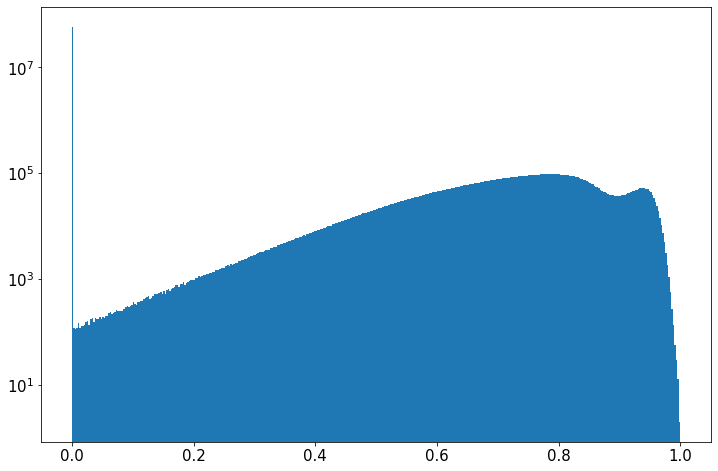

In [12]:
plt.figure(figsize=(12, 8))
plt.yscale('log')
plt.hist(image.flatten(), bins=400);

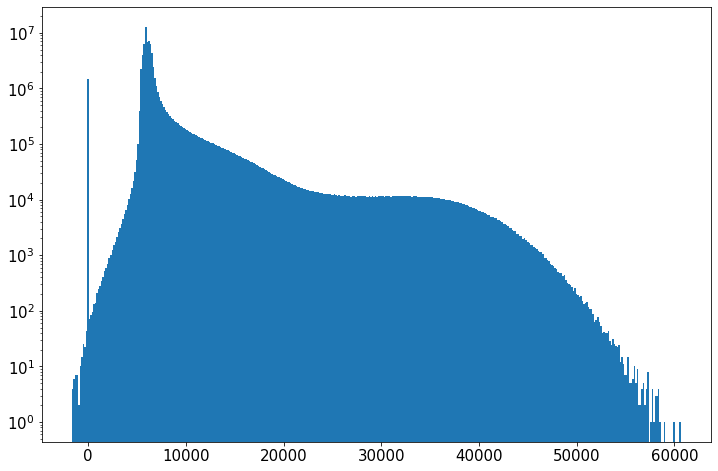

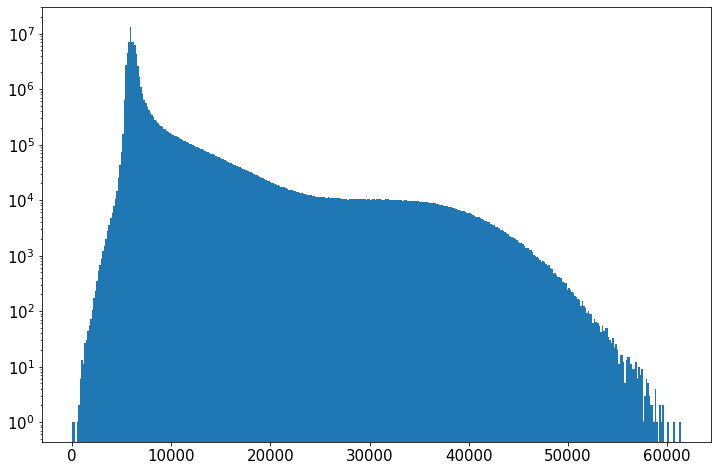

In [20]:
pysreg = tiff.imread(pystackreg_examples[4], key=range(200))
orig = tiff.imread(orig_examples[4], key=range(200))

for image in [pysreg, orig]:
    plt.figure(figsize=(12, 8))
    plt.yscale('log')
    plt.hist(image.flatten(), bins=400);

### COM-T+ECC

In [27]:
# COM-T+ECC
path = orig_examples[4]

print(f'{path=}')
image = tiff.imread(path)
print('loaded image')

t1 = time.perf_counter()
image, params = vxm_preprocessing(image, affine_transform=True)
t2 = time.perf_counter()
print(f'pre-processed image in {t2-t1}s | {image.shape[0]/(t2-t1)} frames/s')
print(f'{params=}')

com = COM(image)
print(f'COM: {com*100:.4f}%')
mse = MSE(image, ref='previous')
print(f'MSE: {mse}')
ncc = NCC(image, ref='previous')
print(f'NCC: {ncc}')
emd_scores = []
for _ in (range(10)):
    emd_scores += [EMD(image, ref='previous')]
    print(f'{emd_scores[-1]} ', end='')
print(f'EMD: {np.mean(emd_scores)} +- {np.std(emd_scores)} | {emd_scores=}')

gc.collect()

make_video('com-t-ecc', frame_gen(image))
Video('com-t-ecc.mov')

path='../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif'
loaded image
pre-com x.min()=0.0 | x.max()=1.0
com x.min()=-5.522920293787775e-16 | x.max()=1.0000000000000004
ecc x.min()=-3.471726e-16 | x.max()=0.9957736


[2022-01-14 00:57:50,138] D T140053586768256 utils.py:146: Applied affine transform to 4100 frames at a rate of 40 frames/s


pre-processed image in 132.6252004597336s | 30.91418513063664 frames/s
params={'low': 0.0, 'hig': 10.95177099386878, 'bg_thresh': 8481.0, 'ref': array([[0.01361343, 0.03810105, 0.02768107, ..., 0.02091256, 0.02498119,
        0.01743435],
       [0.01836793, 0.04259369, 0.02513726, ..., 0.02324251, 0.02472432,
        0.02289358],
       [0.01538434, 0.03938522, 0.02270816, ..., 0.01633265, 0.02027736,
        0.00842888],
       ...,
       [0.02938465, 0.06503162, 0.03833276, ..., 0.01563635, 0.0240633 ,
        0.01331407],
       [0.03709156, 0.07197585, 0.04060062, ..., 0.01725995, 0.02081032,
        0.01255703],
       [0.04788403, 0.08995318, 0.05221301, ..., 0.01652911, 0.02152873,
        0.00613937]]), 'nb_frames': 4100}
COM: 0.0000%
MSE: 0.014456814154982567
NCC: -0.5347168445587158
16.127812494156323 16.11426465640978 16.101391418300526 16.15099950060958 16.20452728064498 16.209986459335052 16.1149708323136 16.102889778564563 16.1284627008466 16.14354321398162 EMD: 16.1398

4100it [00:13, 301.18it/s]
ffmpeg: /home/adrian/miniconda3/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


converting video..
Done (20.78s)


In [28]:
output_path = path.replace('denoised_red.tif', 'com-t_ecc_red')
np.save(output_path, image)

### OFCO

In [4]:
# OFCO
path = ofco_examples[4]

print(f'{path=}')
image = tiff.imread(path)
print('loaded image')

t1 = time.perf_counter()
image, params = vxm_preprocessing(image, affine_transform=False)
t2 = time.perf_counter()
print(f'pre-processed image in {t2-t1}s')

com = COM(image)
print(f'COM: {com*100:.4f}%')
mse = MSE(image, ref='previous')
print(f'MSE: {mse}')
ncc = NCC(image, ref='previous')
print(f'NCC: {ncc}')
emd_scores = []
for _ in tqdm(range(10)):
    emd_scores += [EMD(image, ref='previous')]
print(f'EMD: {np.mean(emd_scores)} +- {np.std(emd_scores)} | {emd_scores=}')

del image
gc.collect()

path='../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/warped_red.tif'
loaded image
pre-processed image in 30.87372674300059s
COM: 0.0000%
MSE: 0.01872944843566874
NCC: -0.6368662118911743
EMD: 15.582152576301468


0

In [6]:
from tqdm import tqdm
# OFCO

emd_scores = []
for _ in tqdm(range(10)):
    emd_scores += [EMD(image, ref='previous')]

print(f'EMD: {np.mean(emd_scores)} +- {np.std(emd_scores)}')

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [24:54<00:00, 149.49s/it]

EMD: 15.650980508476371 +- 0.04056713343819057


### voxelmorph 'first'

In [ ]:
from stabilize2p.utils import get_strategy, vxm_data_generator
# Voxelmorph
strategy = get_strategy('GPU')
path = orig_examples[4]

print(f'{path=}')
store_params = []
val_generator = vxm_data_generator(path,
                                   batch_size=64,
                                   training=False,
                                   ref='first',
                                   store_params=store_params)
print('loaded image')

with strategy.scope():
    model = vxm.networks.VxmDense.load('../models/vxm_drosophila_2d_1900.h5')
print('loaded model')

t1 = time.perf_counter()
with strategy.scope():
    image = []
    for val_in, _ in val_generator:
        image += [model.predict(val_in)[0].squeeze()]
    image = np.concatenate(image, axis=0)
t2 = time.perf_counter()
del model
print(f'{image.shape=}')

In [10]:
print(f'predicted image in {t2-t1}s | {image.shape[0]/(t2-t1):.4f} frames/s')

com = COM(image)
print(f'COM: {com*100:.4f}%')
mse = MSE(image, ref='previous')
print(f'MSE: {mse}')
ncc = NCC(image, ref='previous')
print(f'NCC: {ncc}')
emd_scores = []
for _ in tqdm(range(10)):
    emd_scores += [EMD(image, ref='previous')]
print(f'EMD: {np.mean(emd_scores)} +- {np.std(emd_scores)} | {emd_scores=}')

gc.collect()

make_video('out', frame_gen(image))
Video('out.mov')

COM: 0.0000%
MSE: 0.006423514802008867
NCC: -0.6556775569915771


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [14:10<00:00, 85.08s/it]


EMD: 29.55494702130169 +- 0.04009278398524888 | emd_scores=[29.47883629489709, 29.541540937534844, 29.611119644314204, 29.587803628022556, 29.58017947077754, 29.54677834852866, 29.583262999233398, 29.58916450764101, 29.52094302185825, 29.50984136020933]


4100it [00:11, 347.77it/s]
ffmpeg: /home/adrian/miniconda3/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


converting video..
Done (12.39s)


### Voxelmorph 'previous'

In [3]:
from stabilize2p.utils import get_strategy, vxm_data_generator
# Voxelmorph
logging.getLogger('stabilize2p').setLevel(logging.INFO)
strategy = get_strategy('GPU')
path = orig_examples[4]
output_path = path.replace('denoised_red.tiff', 'vxm_red')

print(f'{path=}')
store_params = []
val_generator = vxm_data_generator(path,
                                   batch_size=64,
                                   training=False,
                                   ref='previous',
                                   store_params=store_params)
print('loaded image')

with strategy.scope():
    model = vxm.networks.VxmDense.load('../models/vxm_drosophila_2d_1900.h5')
print('loaded model')

t1 = time.perf_counter()
with strategy.scope():
    image = []
    for val_in, _ in val_generator:
        print('.', end='')
        image += [model.predict(val_in)[0].squeeze()]
    image = np.concatenate(image, axis=0)
t2 = time.perf_counter()
del model
print(f'{image.shape=}')
np.save(output_path, image)
print('SAVED')

[2022-01-14 01:18:14,451] I T140545489879424 utils.py:1003: Num Physical GPUs Available: 1
[2022-01-14 01:18:14,823] I T140545489879424 utils.py:1004: Num Logical  GPUs Available: 1
[2022-01-14 01:18:14,823] I T140545489879424 utils.py:1005: Num TPUs Available: 0
[2022-01-14 01:18:14,823] W T140545489879424 utils.py:1015: GPU device "PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')" is already initialized.


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


[2022-01-14 01:18:14,827] I T140545489879424 utils.py:1031: using GPU "MirroredStrategy" strategy.


path='../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif'
loaded image
loaded model


[2022-01-14 01:18:41,744] I T140545489879424 utils.py:280: Calculated "previous" fixed references in 25.8s


.................................................................image.shape=(4100, 480, 736)


In [4]:
print(f'predicted image in {t2-t1}s | {image.shape[0]/(t2-t1):.4f} frames/s')

com = COM(image)
print(f'COM: {com*100:.4f}%')
mse = MSE(image, ref='previous')
print(f'MSE: {mse}')
ncc = NCC(image, ref='previous')
print(f'NCC: {ncc}')
emd_scores = []
for _ in (range(10)):
    emd_scores += [EMD(image, ref='previous')]
    print(f'{emd_scores[-1]} ', end='')
print(f'EMD: {np.mean(emd_scores)} +- {np.std(emd_scores)} | {emd_scores=}')

gc.collect()

make_video('out', frame_gen(image))
Video('out.mov')

predicted image in 203.53536432608962s | 20.1439 frames/s
COM: 0.0000%
MSE: 0.006306125316768885
NCC: -0.647982120513916


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [13:01<00:00, 78.20s/it]


EMD: 14.800949229852241 +- 0.04626280315351606 | emd_scores=[14.696033738221635, 14.83231994743954, 14.855169562792703, 14.761782212612697, 14.787909394792264, 14.805385427360434, 14.842021117474964, 14.772854218185321, 14.80792289905294, 14.848093780589911]


4100it [00:11, 346.54it/s]
ffmpeg: /home/adrian/miniconda3/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


converting video..
Done (11.34s)


### Hypermorph 'first'

In [5]:
from stabilize2p.utils import get_strategy, hypermorph_optimal_register
# Hypermorph
logging.getLogger('stabilize2p').setLevel(logging.INFO)
strategy = get_strategy('default')
path = orig_examples[4]

print(f'{path=}')

t1 = time.perf_counter()
store_params = []
image = hypermorph_optimal_register(path,
                                    '../models/hypm_drosophila_2d_1300.h5',
                                    num_hyp=8,
                                    store_params=store_params,
                                    undo_preprocessing_output=False,
                                    data_generator_kw=dict(batch_size=128,
                                                           ref='first'))
t2 = time.perf_counter()
print(f'{image.shape=}')

[2022-01-12 00:52:10,376] I T140440371691904 utils.py:1254: Num Physical GPUs Available: 0
[2022-01-12 00:52:10,385] I T140440371691904 utils.py:1255: Num Logical  GPUs Available: 0
[2022-01-12 00:52:10,387] I T140440371691904 utils.py:1256: Num TPUs Available: 0
[2022-01-12 00:52:10,390] I T140440371691904 utils.py:1286: using default strategy.


path='../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif'
Instructions for updating:
Use fn_output_signature instead


[2022-01-12 00:52:12,774] I T140440371691904 utils.py:114: model input shape:  (None, 480, 736, 1), (None, 480, 736, 1), (None, 1)
[2022-01-12 00:52:12,775] I T140440371691904 utils.py:115: model output shape: (None, 480, 736, 1), (None, 240, 368, 2)
[2022-01-12 00:52:57,936] I T140440371691904 utils.py:532: Calculated "first" fixed references in 45.2s
100%|█████████████████████████████████████████████████████████████████████████████| 4099/4099 [50:50<00:00,  1.34it/s]
[2022-01-12 01:45:56,065] I T140440371691904 utils.py:238: Calcuated scores. Elapsed 3052.87s | 1 frames/s | 0.7446 s/frame
[2022-01-12 01:46:15,109] I T140440371691904 utils.py:250: Calcuated shortest paths. Elapsed 19.0436s
[2022-01-12 01:46:15,109] I T140440371691904 utils.py:251: Shortest path scores: 
[[-665.49052111 -665.69144181 -665.70780196 -665.71769605 -665.71964263
  -665.72022978 -665.72041238 -665.71882602]
 [-665.55958747 -665.76050817 -665.77686832 -665.78676241 -665.78870899
  -665.78929614 -665.78947874

image.shape=(4100, 480, 736)


In [6]:
print(f'predicted image in {t2-t1}s | {image.shape[0]/(t2-t1):.4f} frames/s')

com = COM(image)
print(f'COM: {com*100:.4f}%')
mse = MSE(image, ref='previous')
print(f'MSE: {mse}')
ncc = NCC(image, ref='previous')
print(f'NCC: {ncc}')
emd_scores = []
for _ in tqdm(range(10)):
    emd_scores += [EMD(image, ref='previous')]
print(f'EMD: {np.mean(emd_scores)} +- {np.std(emd_scores)} | {emd_scores=}')

gc.collect()

make_video('out', frame_gen(image))
Video('out.mov')

predicted image in 3531.6267582289875s | 1.1609 frames/s
COM: 0.0000%
MSE: 0.009477434679865837
NCC: -0.5044214725494385


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [14:05<00:00, 84.52s/it]


EMD: 29.271343707436948 +- 0.07267069068645816 | emd_scores=[29.336048140033103, 29.304862941472052, 29.294320613519105, 29.317467771227648, 29.29536954453399, 29.16284744258263, 29.114441526533167, 29.235668049198434, 29.343313384784178, 29.30909766048522]


4100it [00:12, 335.95it/s]
ffmpeg: /home/adrian/miniconda3/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


converting video..
Done (18.73s)


### Hypermorph 'previous'

#### CPU

In [7]:
import gc
import logging
from tqdm import tqdm
from stabilize2p.utils import get_strategy
from stabilize2p.register import hypermorph_optimal_transform
# Hypermorph
logging.getLogger('stabilize2p').setLevel(logging.INFO)
path = orig_examples[4]
output_path = path.replace('denoised_red.tiff', 'hypermorph_red.cpu')

print(f'{path=} | {output_path=}')

strategy = get_strategy('default')  # YOU MUST ALSO SET CUDA_VISIBLE_DEVICES TO -1!

t1 = time.perf_counter()
store_params = []
image = hypermorph_optimal_transform(path,
                                     '../models/hypm_drosophila_2d_1300.h5',
                                     num_hyp=8,
                                     strategy=strategy,
                                     store_params=store_params,
                                     undo_preprocessing_output=False,
                                     data_generator_kw=dict(batch_size=128,
                                                            ref='previous'))
t2 = time.perf_counter()
print(f'{image.shape=}')
print(f'predicted image in {t2-t1}s | {image.shape[0]/(t2-t1):.4f} frames/s')

np.save(output_path, image)
print('SAVED')

[2022-01-14 01:41:01,420] I T140545489879424 utils.py:1003: Num Physical GPUs Available: 1
[2022-01-14 01:41:01,420] I T140545489879424 utils.py:1004: Num Logical  GPUs Available: 1
[2022-01-14 01:41:01,420] I T140545489879424 utils.py:1005: Num TPUs Available: 0
[2022-01-14 01:41:01,421] W T140545489879424 utils.py:1015: GPU device "PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')" is already initialized.
[2022-01-14 01:41:01,421] I T140545489879424 utils.py:1035: using default strategy.


path='../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif' | output_path='../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif'


[2022-01-14 01:41:02,188] I T140545489879424 register.py:269: model input shape:  (None, 480, 736, 1), (None, 480, 736, 1), (None, 1)
[2022-01-14 01:41:02,189] I T140545489879424 register.py:270: model output shape: (None, 480, 736, 1), (None, 240, 368, 2)
[2022-01-14 01:41:48,700] I T140545489879424 utils.py:280: Calculated "previous" fixed references in 46.5s
100%|█████████████████████████████████████████████████████████████████████████████| 4099/4099 [13:50<00:00,  4.94it/s]
[2022-01-14 01:57:37,211] I T140545489879424 register.py:386: Calcuated scores. Elapsed 831.50s | 5 frames/s | 0.2028 s/frame
[2022-01-14 01:57:55,011] I T140545489879424 register.py:398: Calcuated shortest paths. Elapsed 17.7996s
[2022-01-14 01:57:55,012] I T140545489879424 register.py:399: Shortest path scores: 
[[-674.70789975 -674.89247037 -674.90415497 -674.91065763 -674.91057794
  -674.90988301 -674.90871063 -674.90634219]
 [-674.77755436 -674.96212498 -674.97380958 -674.98031224 -674.98023254
  -674.97953

image.shape=(4100, 480, 736)
predicted image in 1078.7216566614807s | 3.8008 frames/s
SAVED


In [8]:
from stabilize2p.metrics import COM, MSE, NCC, EMD

com = COM(image)
print(f'COM: {com*100:.4f}%')
mse = MSE(image, ref='previous')
print(f'MSE: {mse}')
ncc = NCC(image, ref='previous')
print(f'NCC: {ncc}')
emd_scores = []
for _ in tqdm(range(10)):
    emd_scores += [EMD(image, ref='previous')]
print(f'EMD: {np.mean(emd_scores)} +- {np.std(emd_scores)} | {emd_scores=}')

gc.collect()

make_video('out', frame_gen(image))
Video('out.mov')

COM: 0.0000%
MSE: 0.008648828603327274
NCC: -0.5389204025268555


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [13:07<00:00, 78.79s/it]


EMD: 15.721390114436284 +- 0.027634935392447255 | emd_scores=[15.715792338158522, 15.722279994267556, 15.706820529539785, 15.657327968652167, 15.710268205486226, 15.7444606469248, 15.711747535191115, 15.748315244361462, 15.73520070831699, 15.761687973464198]


4100it [00:12, 332.78it/s]
ffmpeg: /home/adrian/miniconda3/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


converting video..
Done (18.89s)


#### GPU

In [13]:
import gc
import logging
from tqdm import tqdm
from stabilize2p.utils import get_strategy
from stabilize2p.register import hypermorph_optimal_register
# Hypermorph
logging.getLogger('stabilize2p').setLevel(logging.INFO)
path = orig_examples[4]
output_path = path.replace('denoised_red.tif', 'hypermorph_red.gpu')

print(f'{path=} | {output_path=}')

t1 = time.perf_counter()
store_params = []
image = hypermorph_optimal_register(path,
                                    '../models/hypm_drosophila_2d_1300.h5',
                                    num_hyp=8,
                                    store_params=store_params,
                                    undo_preprocessing_output=False,
                                    data_generator_kw=dict(batch_size=128,
                                                           ref='previous'))
t2 = time.perf_counter()
print(f'{image.shape=}')
print(f'predicted image in {t2-t1}s | {image.shape[0]/(t2-t1):.4f} frames/s')

np.save(output_path, image)
print('SAVED')

[2022-01-13 22:19:11,082] I T140391138967936 utils.py:1000: Num Physical GPUs Available: 1
[2022-01-13 22:19:11,082] I T140391138967936 utils.py:1001: Num Logical  GPUs Available: 1
[2022-01-13 22:19:11,082] I T140391138967936 utils.py:1002: Num TPUs Available: 0
[2022-01-13 22:19:11,083] W T140391138967936 utils.py:1012: GPU device "PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')" is already initialized.


path='../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif' | output_path='../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/hypermorph_red.tif'
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


[2022-01-13 22:19:11,085] I T140391138967936 utils.py:1028: using GPU "MirroredStrategy" strategy.
[2022-01-13 22:19:11,939] I T140391138967936 register.py:235: model input shape:  (None, 480, 736, 1), (None, 480, 736, 1), (None, 1)
[2022-01-13 22:19:11,940] I T140391138967936 register.py:236: model output shape: (None, 480, 736, 1), (None, 240, 368, 2)
[2022-01-13 22:19:50,177] I T140391138967936 utils.py:277: Calculated "previous" fixed references in 38.2s
100%|█████████████████████████████████████████████████████████████████████████████| 4099/4099 [16:38<00:00,  4.10it/s]
[2022-01-13 22:38:26,533] I T140391138967936 register.py:352: Calcuated scores. Elapsed 1000.54s | 4 frames/s | 0.2440 s/frame
[2022-01-13 22:38:45,088] I T140391138967936 register.py:364: Calcuated shortest paths. Elapsed 18.5553s
[2022-01-13 22:38:45,089] I T140391138967936 register.py:365: Shortest path scores: 
[[-680.89044426 -681.07690825 -681.08929061 -681.09536757 -681.09502029
  -681.09356687 -681.09203967

image.shape=(4100, 480, 736)
predicted image in 1248.6319152899086s | 3.2836 frames/s
SAVED


In [15]:
from stabilize2p.metrics import COM, MSE, NCC, EMD

com = COM(image)
print(f'COM: {com*100:.4f}%')
mse = MSE(image, ref='previous')
print(f'MSE: {mse}')
ncc = NCC(image, ref='previous')
print(f'NCC: {ncc}')
emd_scores = []
for _ in tqdm(range(10)):
    emd_scores += [EMD(image, ref='previous')]
print(f'EMD: {np.mean(emd_scores)} +- {np.std(emd_scores)} | {emd_scores=}')

gc.collect()

make_video('out', frame_gen(image))
Video('out.mov')

COM: 0.0000%
MSE: 0.008389092981815338
NCC: -0.5217446684837341


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [14:00<00:00, 84.06s/it]


EMD: 29.812184899609587 +- 0.05645667149508452 | emd_scores=[29.782237555685892, 29.71894722751925, 29.8261375264954, 29.84776320771466, 29.899629440798137, 29.816186410972175, 29.838635507368295, 29.715364291139835, 29.809282224244942, 29.867665604157242]


4100it [00:12, 341.30it/s]
ffmpeg: /home/adrian/miniconda3/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


converting video..
Done (16.20s)


### voxelmorph repeats

vxm + ofco takes too much time and barely improves

In [8]:
keys = [range(500)]
nb_repeats = 30

import ofco
from stabilize2p.utils import get_strategy, vxm_data_generator

# Voxelmorph
logging.getLogger('stabilize2p').setLevel(logging.INFO)
strategy = get_strategy('GPU')
path = orig_examples[4]

print(f'{path=}')
store_params = []
val_generator = vxm_data_generator(path,
                                   batch_size=16,
                                   training=False,
                                   keys=keys,
                                   ref='previous',
                                   store_params=store_params)
print('loaded image')

with strategy.scope():
    model = vxm.networks.VxmDense.load('../models/vxm_drosophila_2d_1900.h5')
print('loaded model')

t1 = time.perf_counter()
with strategy.scope():
    image = []
    for val_in, _ in val_generator:
        print('.', end='')
        batch = model.predict(val_in)[0]
        for i in range(nb_repeats-1):
            batch = model.predict((batch, val_in[1]))[0]
        image += [batch.squeeze()]
    image = np.concatenate(image, axis=0)
t2 = time.perf_counter()
print(f'{image.shape=}')
print(f'predicted vxm image in {t2-t1}s | {image.shape[0]/(t2-t1):.4f} frames/s')
del model, val_generator
np.save('backup', image)

[2022-01-12 09:28:57,965] I T139958373327232 utils.py:1254: Num Physical GPUs Available: 1
[2022-01-12 09:28:57,965] I T139958373327232 utils.py:1255: Num Logical  GPUs Available: 1
[2022-01-12 09:28:57,966] I T139958373327232 utils.py:1256: Num TPUs Available: 0
[2022-01-12 09:28:57,966] W T139958373327232 utils.py:1266: GPU device "PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')" is already initialized.


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


[2022-01-12 09:28:57,968] I T139958373327232 utils.py:1282: using GPU "MirroredStrategy" strategy.


path='../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif'
loaded image
loaded model


[2022-01-12 09:29:00,966] I T139958373327232 utils.py:532: Calculated "previous" fixed references in 2.81s


................................image.shape=(500, 480, 736)
predicted vxm image in 230.36140149459243s | 2.1705 frames/s


In [9]:
com = COM(image)
print(f'COM: {com*100:.4f}%')
mse = MSE(image, ref='previous')
print(f'MSE: {mse}')
ncc = NCC(image, ref='previous')
print(f'NCC: {ncc}')
emd_scores = []
for _ in tqdm(range(10)):
    emd_scores += [EMD(image, ref='previous')]
    print(f'{emd_scores[-1]} ', end='')
print(f'EMD: {np.mean(emd_scores)} +- {np.std(emd_scores)} | {emd_scores=}')

gc.collect()

make_video('out', frame_gen(image))
Video('out.mov')

COM: 0.0000%
MSE: 0.005315887741744518
NCC: -0.5275697112083435


 10%|████████▏                                                                         | 1/10 [00:10<01:34, 10.46s/it]

24.179824079962412 

 20%|████████████████▍                                                                 | 2/10 [00:20<01:23, 10.39s/it]

23.97056040383932 

 30%|████████████████████████▌                                                         | 3/10 [00:31<01:12, 10.39s/it]

23.884869892356626 

 40%|████████████████████████████████▊                                                 | 4/10 [00:41<01:02, 10.35s/it]

24.036356520458586 

 50%|█████████████████████████████████████████                                         | 5/10 [00:51<00:51, 10.37s/it]

23.909317551325188 

 60%|█████████████████████████████████████████████████▏                                | 6/10 [01:02<00:41, 10.38s/it]

24.05097591967449 

 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [01:12<00:31, 10.41s/it]

23.845318905604383 

 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [01:23<00:20, 10.43s/it]

23.970106614096597 

 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [01:33<00:10, 10.40s/it]

23.764163753697787 

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [01:44<00:00, 10.40s/it]


24.14653898960119 EMD: 23.975803263061657 +- 0.12436214212910618 | emd_scores=[24.179824079962412, 23.97056040383932, 23.884869892356626, 24.036356520458586, 23.909317551325188, 24.05097591967449, 23.845318905604383, 23.970106614096597, 23.764163753697787, 24.14653898960119]


500it [00:01, 359.52it/s]
ffmpeg: /home/adrian/miniconda3/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


converting video..
Done (1.39s)


In [5]:
com = COM(image)
print(f'COM: {com*100:.4f}%')
mse = MSE(image, ref='previous')
print(f'MSE: {mse}')
ncc = NCC(image, ref='previous')
print(f'NCC: {ncc}')
emd_scores = []
for _ in tqdm(range(10)):
    emd_scores += [EMD(image, ref='previous')]
    print(f'{emd_scores[-1]} ', end='')
print(f'EMD: {np.mean(emd_scores)} +- {np.std(emd_scores)} | {emd_scores=}')

gc.collect()

make_video('out', frame_gen(image))
Video('out.mov')

COM: 0.0000%
MSE: 0.005128398071974516
NCC: -0.5752424597740173


 10%|████████▏                                                                         | 1/10 [00:10<01:30, 10.07s/it]

26.595463943447406 

 20%|████████████████▍                                                                 | 2/10 [00:20<01:21, 10.16s/it]

26.95790009393545 

 30%|████████████████████████▌                                                         | 3/10 [00:30<01:11, 10.20s/it]

26.718824445940278 

 40%|████████████████████████████████▊                                                 | 4/10 [00:40<01:01, 10.19s/it]

26.912139524697583 

 50%|█████████████████████████████████████████                                         | 5/10 [00:50<00:50, 10.19s/it]

26.92640762720799 

 60%|█████████████████████████████████████████████████▏                                | 6/10 [01:01<00:40, 10.19s/it]

26.80851255876886 

 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [01:11<00:30, 10.18s/it]

26.630766902086044 

 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [01:21<00:20, 10.17s/it]

26.409122505446817 

 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [01:31<00:10, 10.20s/it]

26.859817384609446 

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [01:42<00:00, 10.20s/it]


27.078118160737823 EMD: 26.789707314687767 +- 0.19059827592253453 | emd_scores=[26.595463943447406, 26.95790009393545, 26.718824445940278, 26.912139524697583, 26.92640762720799, 26.80851255876886, 26.630766902086044, 26.409122505446817, 26.859817384609446, 27.078118160737823]


500it [00:01, 358.54it/s]
ffmpeg: /home/adrian/miniconda3/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


converting video..
Done (1.35s)


## Method scores bar plots

In [9]:
score_names = ['COM', 'MSE', 'NCC', 'EMD-mean', 'EMD-std']
scores = {
    'PyStackReg': [0.8780, 0.0253, 0.579, 17.2, 0.03],
    'COM-T+ECC': [0, 0.0145, 0.535, 16.1, 0.04],
    'VoxelMorph': [0, 0.0063, 0.648, 14.8, 0.05],
    'HyperMorph': [0, 0.0086, 0.539, 15.7, 0.03],
    'OFCO': [0, 0.0187, 0.637, 15.6, 0.04],
}

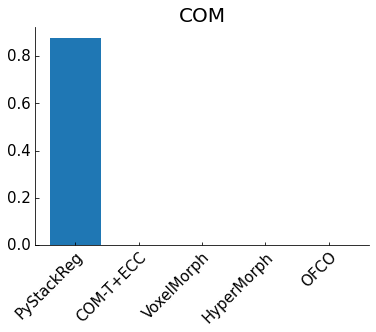

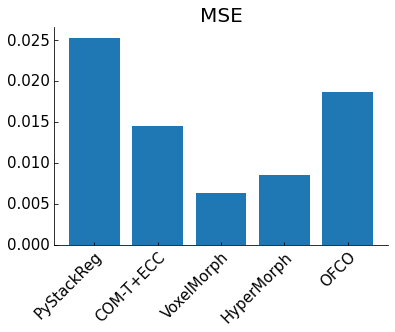

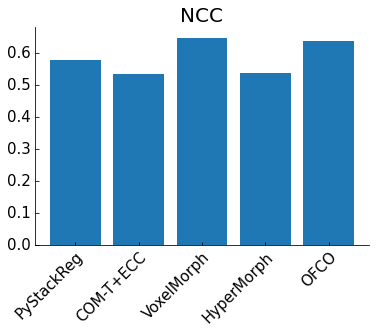

In [10]:
for si, sc_name in enumerate(score_names[:3]):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4),
                           subplot_kw=dict(axes_class=AA.Axes))

    for direction in ["right", "top"]:
        # hides borders
        ax.axis[direction].set_visible(False)

    vals = [v[si] for v in scores.values()]
    xaxis = [method for method in scores.keys()]
    plt.bar(xaxis, vals)
    plt.xticks(rotation=45)
    ax.set_title(sc_name)
    ax.axis['bottom'].major_ticklabels.set_rotation(45)
    ax.axis['bottom'].major_ticklabels.set_va('top')
    ax.axis['bottom'].major_ticklabels.set_ha('right')
    # ax.axis['bottom'].label.set_x(40.0)
    plt.show()

/tmp/ipykernel_1577000/552054397.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([None] + [method for method in scores.keys()])


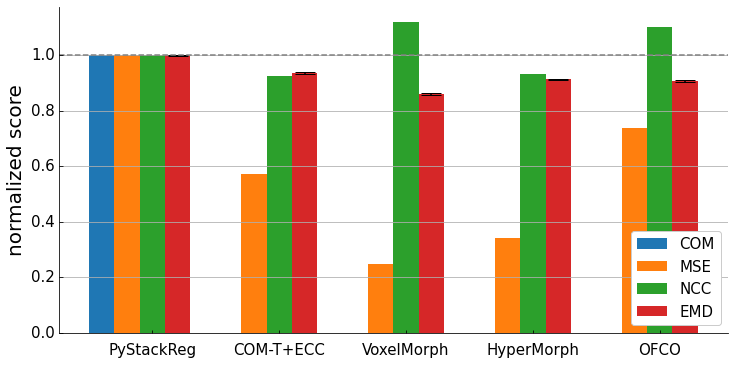

In [15]:
from mpl_toolkits.axes_grid1 import host_subplot

w = 0.2
scales = 1/np.array(scores['PyStackReg'])

fig, ax = plt.subplots(1, 1, figsize=(12, 6),
                       subplot_kw=dict(axes_class=AA.Axes))

for direction in ["right", "top"]:
    # hides borders
    ax.axis[direction].set_visible(False)

xaxis = np.arange(len(scores))

cmap = plt.cm.tab10

for si, sc_name in enumerate(score_names[:4]):
    vals = np.array([v[si] for v in scores.values()])
    # xaxis = [method for method in scores.keys()]
    label = 'EMD' if sc_name == 'EMD-mean' else sc_name
    ax.bar(xaxis + w*(si-2), vals * scales[si], width=w, label=label, color=cmap(si))
    if label == 'EMD':
        yerr = np.array([v[4] for v in scores.values()])
        ax.errorbar(xaxis + w*(si-2), vals * scales[si],
                    yerr=yerr * scales[si], color='k', ls='None',
                    capsize=10)

ax.axhline(1.0, ls='--', color='grey')
ax.grid(axis='y')
ax.set_ylabel('normalized score')

ax.set_xticklabels([None] + [method for method in scores.keys()])
ax.axis['bottom'].major_ticklabels.set_pad(10)
ax.legend(loc='lower right', framealpha=1)

plt.savefig('report/results/bar-plot.pdf')
plt.show()

/tmp/ipykernel_1577000/2775204237.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([None] + [method for method in speeds.keys()])


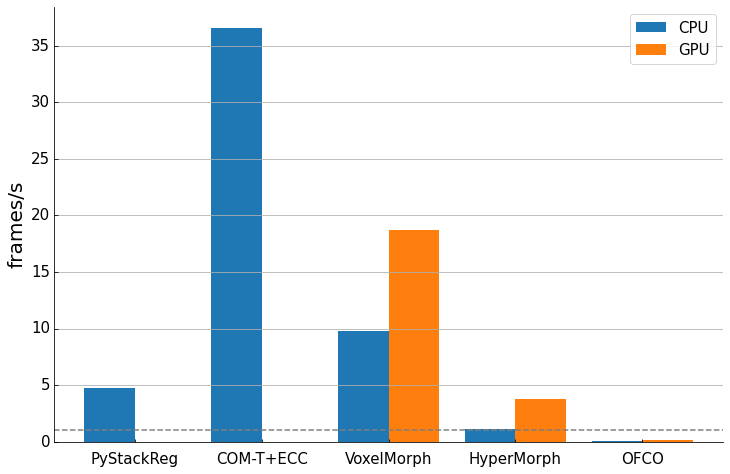

In [21]:
from mpl_toolkits.axes_grid1 import host_subplot

speed_names = ['CPU', 'GPU']

speeds = {
    'PyStackReg': [4.73, 0.0],
    'COM-T+ECC': [36.6, 0.0],
    'VoxelMorph': [9.78, 18.7],
    'HyperMorph': [1.17, 3.8],
    'OFCO': [0.100, 0.143],
}

w = 0.4

fig, ax = plt.subplots(1, 1, figsize=(12, 8),
                       subplot_kw=dict(axes_class=AA.Axes))

for direction in ["right", "top"]:
    # hides borders
    ax.axis[direction].set_visible(False)

xaxis = np.arange(len(speeds))

cmap = plt.cm.tab10

for si, sp_name in enumerate(speed_names):
    vals = np.array([v[si] for v in speeds.values()])
    # xaxis = [method for method in scores.keys()]
    label = sp_name
    ax.bar(xaxis - w/2*((-1)**si), vals, width=w, label=label, color=cmap(si))

ax.axhline(1.0, ls='--', color='grey')
ax.grid(axis='y')
ax.set_ylabel('frames/s')

ax.set_xticklabels([None] + [method for method in speeds.keys()])
ax.axis['bottom'].major_ticklabels.set_pad(10)
ax.legend()

plt.savefig('report/results/bar-speeds.pdf')
plt.show()

\textbf{Method} & COM & MSE & NCC & EMD & (CPU) & (GPU) \\
\hline
\hline
\textsc{PyStackReg} & \pm $ &  & -- \\
\textsc{COM-T+ECC}  & \pm $ & \textbf{} & -- \\
\textsc{VoxelMorph} & \pm $ &  &  \\
\textsc{HyperMorph} & \pm $ &  & -- \\
\textsc{OFCO}       & \pm }$ &  &  \\